In [8]:
# run `pip install medmnist` in terminal
import medmnist
from medmnist import BloodMNIST

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import ResNet101, ResNet50
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import AUC
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Attention

In [8]:
# downloads bloodmnist.npz file 
# at /Users/username/.medmnist/bloodmnist.npz
# 28 pixel resolution
# image dimension is 28x28x3
# change to download=False to avoid multiple downloading
train_df_28 = BloodMNIST(split="train", download=False)
val_df_28 = BloodMNIST(split="val", download=False)
test_df_28 = BloodMNIST(split="test", download=False)

In [10]:
# train metadata
train_df_28

Dataset BloodMNIST of size 28 (bloodmnist)
    Number of datapoints: 11959
    Root location: /Users/cecejen/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.
    Lice

In [12]:
# validation metadata
val_df_28

Dataset BloodMNIST of size 28 (bloodmnist)
    Number of datapoints: 1712
    Root location: /Users/cecejen/.medmnist
    Split: val
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.
    License

In [14]:
# test metadata
test_df_28

Dataset BloodMNIST of size 28 (bloodmnist)
    Number of datapoints: 3421
    Root location: /Users/cecejen/.medmnist
    Split: test
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.
    Licens

In [16]:
# copy downloaded bloodmnist.npz file to current working directory
# check your current directory to copy the file
# import os
# print(os.getcwd())
# cp -r /Users/username/.medmnist/bloodmnist.npz .
# load in file and check names of attributes
data_28 = np.load("bloodmnist.npz")
data_28.files

['train_images',
 'train_labels',
 'val_images',
 'val_labels',
 'test_images',
 'test_labels']

In [65]:
# mapping label numbers to cell types as in metadata
label_dict = {"0": "basophil", "1": "eosinophil", "2": "erythroblast", \
              "3": "immature granulocytes", "4": "lymphocyte", \
              "5": "monocyte", "6": "neutrophil", "7": "platelet"}

In [20]:
# extracting images and labels
# train set
train_images_28 = data_28["train_images"]
train_labels_28 = data_28["train_labels"].flatten()

# validation_set
val_images_28 = data_28["val_images"]
val_labels_28 = data_28["val_labels"].flatten()

# test_set
test_images_28 = data_28["test_images"]
test_labels_28 = data_28["test_labels"].flatten()

In [26]:
train_distribution = pd.DataFrame()
cell_labels = []
cell_counts = []
cell_props = []
for i in np.arange(8):
    cell_labels.append(label_dict[str(i)])

    count = np.sum(train_labels_28 == i)
    cell_counts.append(count)

    prop = np.round(count/len(train_labels_28), 2)
    cell_props.append(prop)

train_distribution["cell_label"] = cell_labels
train_distribution["cell_counts"] = cell_counts
train_distribution["cell_props"] = cell_props
train_distribution

,cell_label,cell_counts,cell_props
0,basophil,852,0.07
1,eosinophil,2181,0.18
2,erythroblast,1085,0.09
3,immature granulocytes,2026,0.17
4,lymphocyte,849,0.07
5,monocyte,993,0.08
6,neutrophil,2330,0.19
7,platelet,1643,0.14


In [28]:
val_distribution = pd.DataFrame()
cell_labels = []
cell_counts = []
cell_props = []
for i in np.arange(8):
    cell_labels.append(label_dict[str(i)])

    count = np.sum(val_labels_28 == i)
    cell_counts.append(count)

    prop = np.round(count/len(val_labels_28), 2)
    cell_props.append(prop)

val_distribution["cell_label"] = cell_labels
val_distribution["cell_counts"] = cell_counts
val_distribution["cell_props"] = cell_props
val_distribution

,cell_label,cell_counts,cell_props
0,basophil,122,0.07
1,eosinophil,312,0.18
2,erythroblast,155,0.09
3,immature granulocytes,290,0.17
4,lymphocyte,122,0.07
5,monocyte,143,0.08
6,neutrophil,333,0.19
7,platelet,235,0.14


In [30]:
test_distribution = pd.DataFrame()
cell_labels = []
cell_counts = []
cell_props = []
for i in np.arange(8):
    cell_labels.append(label_dict[str(i)])

    count = np.sum(test_labels_28 == i)
    cell_counts.append(count)

    prop = np.round(count/len(test_labels_28), 2)
    cell_props.append(prop)

test_distribution["cell_label"] = cell_labels
test_distribution["cell_counts"] = cell_counts
test_distribution["cell_props"] = cell_props
test_distribution

,cell_label,cell_counts,cell_props
0,basophil,244,0.07
1,eosinophil,624,0.18
2,erythroblast,311,0.09
3,immature granulocytes,579,0.17
4,lymphocyte,243,0.07
5,monocyte,284,0.08
6,neutrophil,666,0.19
7,platelet,470,0.14


In [32]:
# concatenanting all images and labels 
cat_images_28 = np.concatenate([train_images_28, val_images_28, test_images_28])
cat_labels_28 = np.concatenate([train_labels_28, val_labels_28, test_labels_28])

In [34]:
# creating a dictionary as label:[images]
class_dict_28 = {k:[] for k in np.arange(8)}
for i, j in zip(cat_labels_28, cat_images_28):
    class_dict_28[i].append(j)

In [36]:
# calculating the average image for each class
# creating dictionary as label:avg_image
average_dict_28 = {k:[] for k in np.arange(8)}
for i in class_dict_28:
    class_images = class_dict_28[i]
    class_all = np.stack(class_images, axis=0) 
    class_avg = np.mean(class_all, axis=0)
    average_dict_28[i] = class_avg

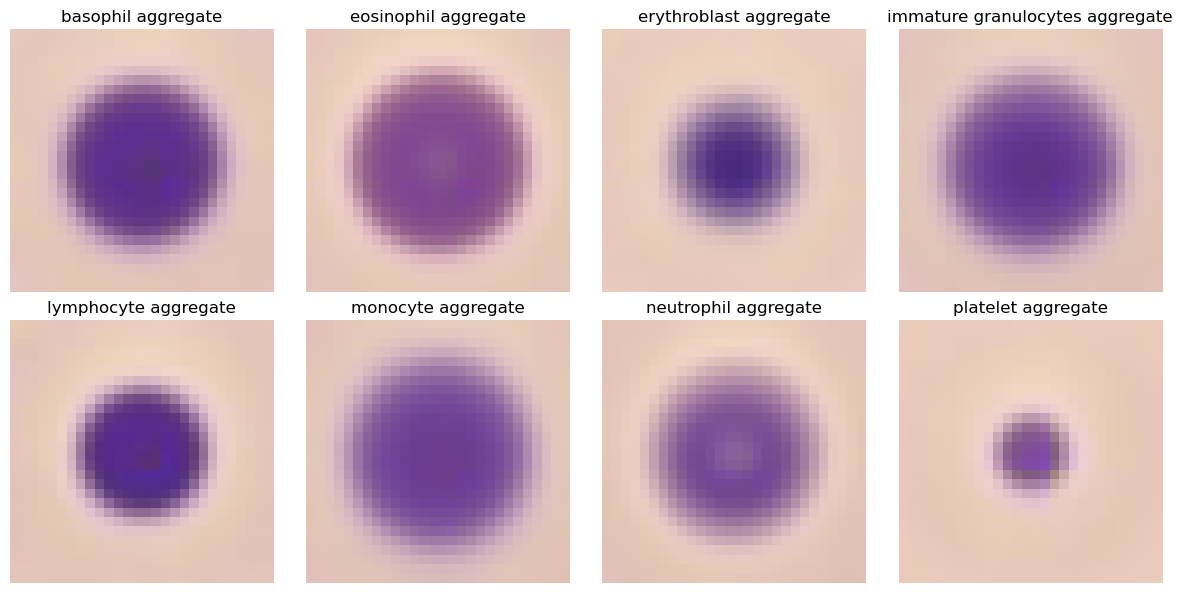

In [37]:
# plotting aggregated images for each cell class
# for 28x28x3 resolution
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    avg_image = average_dict_28[i]
    norm_image = avg_image/255
    ax.imshow(norm_image)  
    ax.axis('off') 
    ax.set_title(f"{label_dict[str(i)]} aggregate") 
plt.tight_layout() 
plt.show()

### Resolution: 224x224

In [40]:
# downloads bloodmnist_224.npz file 
# at /Users/username/.medmnist/bloodmnist_224.npz
# 224 pixel resolution
# image dimension is 224x224x3
train_df_224 = BloodMNIST(split="train", download=False, size=224)
val_df_224 = BloodMNIST(split="val", download=False, size=224)
test_df_224 = BloodMNIST(split="test", download=False, size=224)

In [41]:
# copy downloaded bloodmnist.npz file to current working directory
# cp -r /Users/username/.medmnist/bloodmnist_224.npz .
# load in file and check names of attributes
data_224 = np.load("bloodmnist_224.npz")
data_224.files

['train_images',
 'train_labels',
 'val_images',
 'val_labels',
 'test_images',
 'test_labels']

In [44]:
# extracting images and labels
# train set
train_images_224 = data_224["train_images"]
train_labels_224 = data_224["train_labels"].flatten()

# validation_set
val_images_224 = data_224["val_images"]
val_labels_224 = data_224["val_labels"].flatten()

# test_set
test_images_224 = data_224["test_images"]
test_labels_224 = data_224["test_labels"].flatten()

In [46]:
# concatenanting all images and labels 
cat_images_224 = np.concatenate([train_images_224, val_images_224, test_images_224])
cat_labels_224 = np.concatenate([train_labels_224, val_labels_224, test_labels_224])

In [48]:
# creating a dictionary as label:[images]
class_dict_224 = {k:[] for k in np.arange(8)}
for i, j in zip(cat_labels_224, cat_images_224):
    class_dict_224[i].append(j)

In [50]:
# calculating the average image for each class
# creating dictionary as label:avg_image
average_dict_224 = {k:[] for k in np.arange(8)}
for i in class_dict_224:
    class_images = class_dict_224[i]
    class_all = np.stack(class_images, axis=0) 
    class_avg = np.mean(class_all, axis=0)
    average_dict_224[i] = class_avg

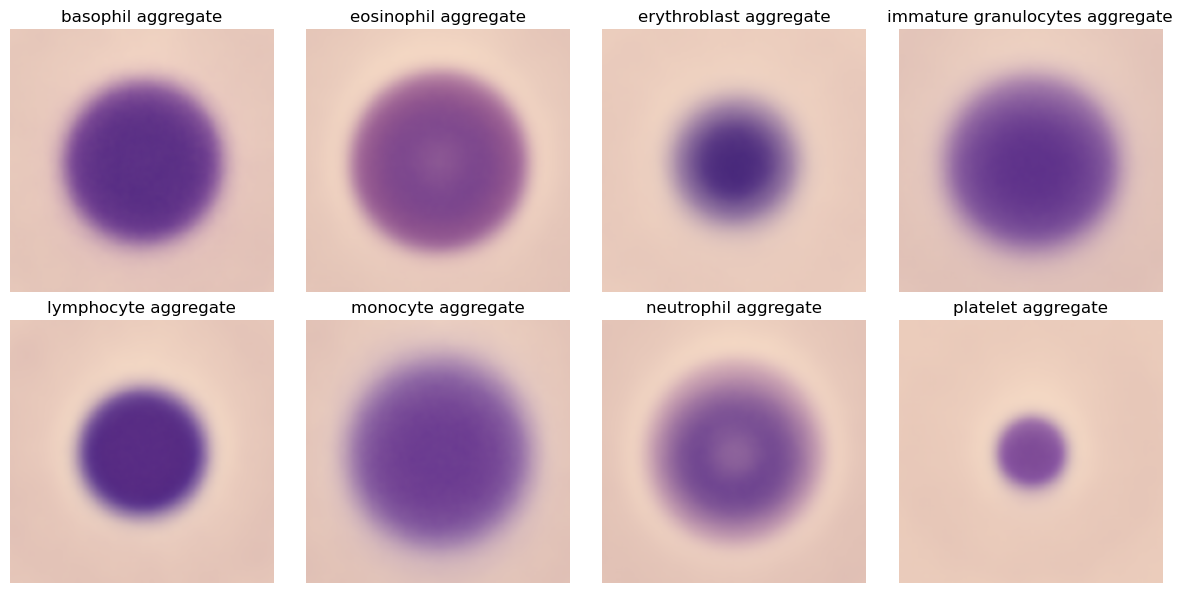

In [52]:
# plotting aggregated images for each cell class
# for 224x224x3 resolution
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    avg_image = average_dict_224[i]
    norm_image = avg_image/255
    ax.imshow(norm_image)  
    ax.axis('off') 
    ax.set_title(f"{label_dict[str(i)]} aggregate") 
plt.tight_layout() 
plt.show()

In [23]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet101, ResNet50
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import AUC
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

In [24]:
print(train_labels_224.shape, val_labels_224.shape, test_labels_224.shape)

(11959,) (1712,) (3421,)


In [25]:
train_labels_cat_224 = to_categorical(train_labels_224, num_classes=8)  # shape (N,8)
val_labels_cat_224   = to_categorical(val_labels_224,   num_classes=8)
test_labels_cat_224  = to_categorical(test_labels_224,  num_classes=8)
print(train_labels_cat_224.shape, val_labels_cat_224.shape, test_labels_cat_224.shape)

(11959, 8) (1712, 8) (3421, 8)


In [26]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
#    preprocessing_function=lambda img: tf.image.resize(img, (28,28))
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
#    preprocessing_function=lambda img: tf.image.resize(img, (28,28))
)

batch_size = 32 # changed to 32

In [27]:
train_generator_224 = train_datagen.flow(
    train_images_224, 
    train_labels_cat_224,   
    batch_size=batch_size
)
val_generator_224 = test_datagen.flow(
    val_images_224,
    val_labels_cat_224,
    batch_size=batch_size
)
test_generator_224 = test_datagen.flow(
    test_images_224,
    test_labels_cat_224,
    batch_size=batch_size,
    shuffle=False
)

In [28]:
# ResNet101: model_101_224

base_101_224 = ResNet101(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)


x = base_101_224.output

# add attention layer: keras.layers.Attention(use_scale=False, score_mode="dot", dropout=0.0, seed=None, **kwargs)
x_reshape = layers.Reshape((-1, x.shape[-1]))(x) # reshape as attention layer expect 3D, ResNet output is 4D (batch_size, 224, 224)
attention = layers.Attention()([x_reshape, x_reshape]) # self-attention, compares each timestep with all others to weigh importance
attention_out = layers.Reshape(x.shape[1:])(attention) # reshape back to 4D to match the original ResNet output

x = layers.Multiply()[(x, attention_out)]
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(8, activation="softmax")(x)

model_101_224 = Model(inputs=base_101_224.input, outputs=outputs)


In [ ]:
for rate in [0.0, 0.2, 0.3, 0.5]:
    print(f"\n=== Training with dropout rate: {rate} ===")

    base_101_64 = ResNet101(include_top=False, weights="imagenet", input_shape=(64, 64, 3))
    x = base_101_64.output

    # Reshape for Attention layer
    x_reshape = layers.Reshape((-1, x.shape[-1]))(x)
    attention = layers.Attention()([x_reshape, x_reshape])
    attention_output = layers.Reshape(x.shape[1:])(attention)

    x = layers.multiply([x, attention_output])
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(rate)(x)
    outputs = layers.Dense(8, activation="softmax")(x)
    model_101_64 = Model(inputs=base_101_64.input, outputs=outputs)

    model_101_64.compile(
        optimizer=Adam(1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy", AUC(name="auc", multi_label=True, num_labels=8)]
    )

    history = model_101_64.fit(
        train_generator_64,
        epochs=10,
        validation_data=val_generator_64,
        verbose=2
    )

    test_loss, test_acc, test_auc = model_101_64.evaluate(test_generator_64)
    print(f"Dropout {rate}: Test Accuracy = {test_acc:.4f}, Test AUC = {test_auc:.4f}")

    # Predictions
    y_prob = model_101_64.predict(test_generator_64)
    y_pred = np.argmax(y_prob, axis=1)
    y_true = test_labels_64

    print("Classification Report:")
    label_dict = {
        "0": "basophil", "1": "eosinophil", "2": "erythroblast", "3": "immature granulocytes",
        "4": "lymphocyte", "5": "monocyte", "6": "neutrophil", "7": "platelet"
    }
    class_names = [label_dict[str(i)] for i in range(8)]
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    per_class_acc = cm.diagonal() / cm.sum(axis=1)
    for i, acc in enumerate(per_class_acc):
        print(f"{class_names[i]:<20s} accuracy: {acc:.4f}")


In [29]:
# Train model_101_224: training set, validation set

#model.compile(
#    optimizer=tf.keras.optimizers.Adam(1e-4),
#    loss="sparse_categorical_crossentropy",
#    metrics=["accuracy", AUC(name="auc", multi_label=True, num_labels=8)]
#)
#
#model.fit(
#    train_generator,
#    epochs=6,
#    validation_data=val_generator
#)

model_101_224.compile(
    optimizer=Adam(1e-4), 
    # the learning rate should be further tuned
    # Adam is usually the first algorithm to try firther, but we can try other optimizers
    loss="categorical_crossentropy",       
    metrics=[
        "accuracy",
        AUC(name="auc", multi_label=True, num_labels=8)
    ]
)
model_101_224.fit(
    train_generator_224,
    epochs=10,
    validation_data=val_generator_224
)

Epoch 1/10
748/748 [==============================] - 1386s 2s/step - loss: 0.1955 - accuracy: 0.9340 - auc: 0.9949 - val_loss: 3.5019 - val_accuracy: 0.3417 - val_auc: 0.7460
Epoch 2/10
748/748 [==============================] - 1372s 2s/step - loss: 0.0904 - accuracy: 0.9717 - auc: 0.9982 - val_loss: 0.0738 - val_accuracy: 0.9784 - val_auc: 0.9990
Epoch 3/10
748/748 [==============================] - 1383s 2s/step - loss: 0.0593 - accuracy: 0.9807 - auc: 0.9991 - val_loss: 0.0482 - val_accuracy: 0.9831 - val_auc: 0.9992
Epoch 4/10
748/748 [==============================] - 1366s 2s/step - loss: 0.0502 - accuracy: 0.9829 - auc: 0.9994 - val_loss: 0.1963 - val_accuracy: 0.9544 - val_auc: 0.9961
Epoch 5/10
748/748 [==============================] - 1358s 2s/step - loss: 0.0478 - accuracy: 0.9832 - auc: 0.9994 - val_loss: 0.0433 - val_accuracy: 0.9866 - val_auc: 0.9998
Epoch 6/10
748/748 [==============================] - 1376s 2s/step - loss: 0.0426 - accuracy: 0.9855 - auc: 0.9993 - va

In [63]:
# Evaluate model_101_224: test dataset

test_loss_101_224, test_acc_101_224, test_auc_101_224 = model_101_224.evaluate(test_generator_224)
print(f"ResNet101 test accuracy for 224 pixels: {test_acc_101_224:.4f}")
print(f"ResNet101 test AUC for 224 pixels:      {test_auc_101_224:.4f}")

214/214 [==============================] - 93s 437ms/step - loss: 0.0464 - accuracy: 0.9880 - auc: 0.9989
ResNet101 test accuracy for 224 pixels: 0.9880
ResNet101 test AUC for 224 pixels:      0.9989


In [59]:
# Precision, recall, f1-score: model_101_224

y_prob_101_224 = model_101_224.predict(test_generator_224)
y_pred_101_224 = np.argmax(y_prob_101_224, axis=1)

y_true_224 = test_labels_224

class_names = [label_dict[str(i)] for i in range(8)]
print(classification_report(y_true_224, y_pred_101_224, target_names=class_names))

214/214 [==============================] - 95s 437ms/step
                       precision    recall  f1-score   support

             basophil       1.00      0.98      0.99       244
           eosinophil       1.00      1.00      1.00       624
         erythroblast       1.00      0.99      0.99       311
immature granulocytes       0.97      0.98      0.97       579
           lymphocyte       0.98      1.00      0.99       243
             monocyte       1.00      0.98      0.99       284
           neutrophil       0.97      0.98      0.98       666
             platelet       1.00      1.00      1.00       470

             accuracy                           0.99      3421
            macro avg       0.99      0.99      0.99      3421
         weighted avg       0.99      0.99      0.99      3421



In [60]:
# Performance by class: model_101_224

cm_101_224 = confusion_matrix(y_true_224, y_pred_101_224)
per_class_acc_101_224 = cm_101_224.diagonal() / cm_101_224.sum(axis=1)
for i, acc in enumerate(per_class_acc_101_224):
    print(f"{class_names[i]:<20s} accuracy: {acc:.4f}")

basophil             accuracy: 0.9795
eosinophil           accuracy: 1.0000
erythroblast         accuracy: 0.9904
immature granulocytes accuracy: 0.9758
lymphocyte           accuracy: 0.9959
monocyte             accuracy: 0.9789
neutrophil           accuracy: 0.9820
platelet             accuracy: 1.0000


In [31]:
# ResNet50 model: model_50_224

base_50_224 = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)

x = base_50_224.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(8, activation="softmax")(x)

model_50_224 = Model(inputs=base_50_224.input, outputs=outputs)

In [32]:
# Train model_50_224

model_50_224.compile(
    optimizer=Adam(1e-4),
    loss="categorical_crossentropy",       
    metrics=[
        "accuracy",
        AUC(name="auc", multi_label=True, num_labels=8)
    ]
)
model_50_224.fit(
    train_generator_224,
    epochs=10,
    validation_data=val_generator_224
)

Epoch 1/10
748/748 [==============================] - 748s 997ms/step - loss: 0.1976 - accuracy: 0.9367 - auc: 0.9952 - val_loss: 2.4636 - val_accuracy: 0.4328 - val_auc: 0.8099
Epoch 2/10
748/748 [==============================] - 750s 1s/step - loss: 0.0866 - accuracy: 0.9704 - auc: 0.9983 - val_loss: 0.0906 - val_accuracy: 0.9673 - val_auc: 0.9988
Epoch 3/10
748/748 [==============================] - 767s 1s/step - loss: 0.0634 - accuracy: 0.9804 - auc: 0.9987 - val_loss: 0.1256 - val_accuracy: 0.9597 - val_auc: 0.9981
Epoch 4/10
748/748 [==============================] - 773s 1s/step - loss: 0.0575 - accuracy: 0.9798 - auc: 0.9993 - val_loss: 0.0664 - val_accuracy: 0.9761 - val_auc: 0.9995
Epoch 5/10
748/748 [==============================] - 764s 1s/step - loss: 0.0487 - accuracy: 0.9834 - auc: 0.9994 - val_loss: 0.1888 - val_accuracy: 0.9363 - val_auc: 0.9952
Epoch 6/10
748/748 [==============================] - 756s 1s/step - loss: 0.0405 - accuracy: 0.9847 - auc: 0.9995 - val_l

In [33]:
# Evaluate model_50_224

test_loss_50_224, test_acc_50_224, test_auc_50_224 = model_50_224.evaluate(test_generator_224)
print(f"ResNet50 test accuracy for 224 pixels: {test_acc_50_224:.4f}")
print(f"ResNet50 test AUC for 224 pixels:      {test_auc_50_224:.4f}")

214/214 [==============================] - 53s 249ms/step - loss: 0.0567 - accuracy: 0.9857 - auc: 0.9985
ResNet50 test accuracy: 0.9857
ResNet50 test AUC:      0.9985


In [61]:
# Precision, recall, f1-score: model_50_224

y_prob_50_224 = model_50_224.predict(test_generator_224)
y_pred_50_224 = np.argmax(y_prob_50_224, axis=1)

y_true_224 = test_labels_224

class_names = [label_dict[str(i)] for i in range(8)]
print(classification_report(y_true_224, y_pred_50_224, target_names=class_names))

214/214 [==============================] - 52s 240ms/step
                       precision    recall  f1-score   support

             basophil       1.00      1.00      1.00       244
           eosinophil       1.00      1.00      1.00       624
         erythroblast       1.00      0.98      0.99       311
immature granulocytes       0.96      0.97      0.97       579
           lymphocyte       0.97      1.00      0.98       243
             monocyte       1.00      0.95      0.97       284
           neutrophil       0.97      0.98      0.98       666
             platelet       1.00      1.00      1.00       470

             accuracy                           0.99      3421
            macro avg       0.99      0.98      0.99      3421
         weighted avg       0.99      0.99      0.99      3421



In [62]:
# Performance by class: model_50_224

cm_50_224 = confusion_matrix(y_true_224, y_pred_50_224)
per_class_acc_50_224 = cm_50_224.diagonal() / cm_50_224.sum(axis=1)
for i, acc in enumerate(per_class_acc_50_224):
    print(f"{class_names[i]:<20s} accuracy: {acc:.4f}")

basophil             accuracy: 0.9959
eosinophil           accuracy: 1.0000
erythroblast         accuracy: 0.9839
immature granulocytes accuracy: 0.9724
lymphocyte           accuracy: 0.9959
monocyte             accuracy: 0.9472
neutrophil           accuracy: 0.9835
platelet             accuracy: 1.0000


### Resolution: 64x64

In [10]:
# downloads bloodmnist_64.npz file 
# at /Users/username/.medmnist/bloodmnist_64.npz
# 64 pixel resolution
# image dimension is 64x64x3
train_df_64 = BloodMNIST(split="train", download=False, size=64)
val_df_64 = BloodMNIST(split="val", download=False, size=64)
test_df_64 = BloodMNIST(split="test", download=False, size=64)

In [12]:
# copy downloaded bloodmnist.npz file to current working directory
# cp -r /Users/username/.medmnist/bloodmnist_64.npz .
# load in file and check names of attributes
data_64 = np.load("bloodmnist_64.npz")
data_64.files

['train_images',
 'train_labels',
 'val_images',
 'val_labels',
 'test_images',
 'test_labels']

In [14]:
# extracting images and labels
# train set
train_images_64 = data_64["train_images"]
train_labels_64 = data_64["train_labels"].flatten()

# validation_set
val_images_64 = data_64["val_images"]
val_labels_64 = data_64["val_labels"].flatten()

# test_set
test_images_64 = data_64["test_images"]
test_labels_64 = data_64["test_labels"].flatten()

In [16]:
# concatenanting all images and labels 
cat_images_64 = np.concatenate([train_images_64, val_images_64, test_images_64])
cat_labels_64 = np.concatenate([train_labels_64, val_labels_64, test_labels_64])

In [18]:
# creating a dictionary as label:[images]
class_dict_64 = {k:[] for k in np.arange(8)}
for i, j in zip(cat_labels_64, cat_images_64):
    class_dict_64[i].append(j)

In [20]:
# calculating the average image for each class
# creating dictionary as label:avg_image
average_dict_64 = {k:[] for k in np.arange(8)}
for i in class_dict_64:
    class_images = class_dict_64[i]
    class_all = np.stack(class_images, axis=0) 
    class_avg = np.mean(class_all, axis=0)
    average_dict_64[i] = class_avg

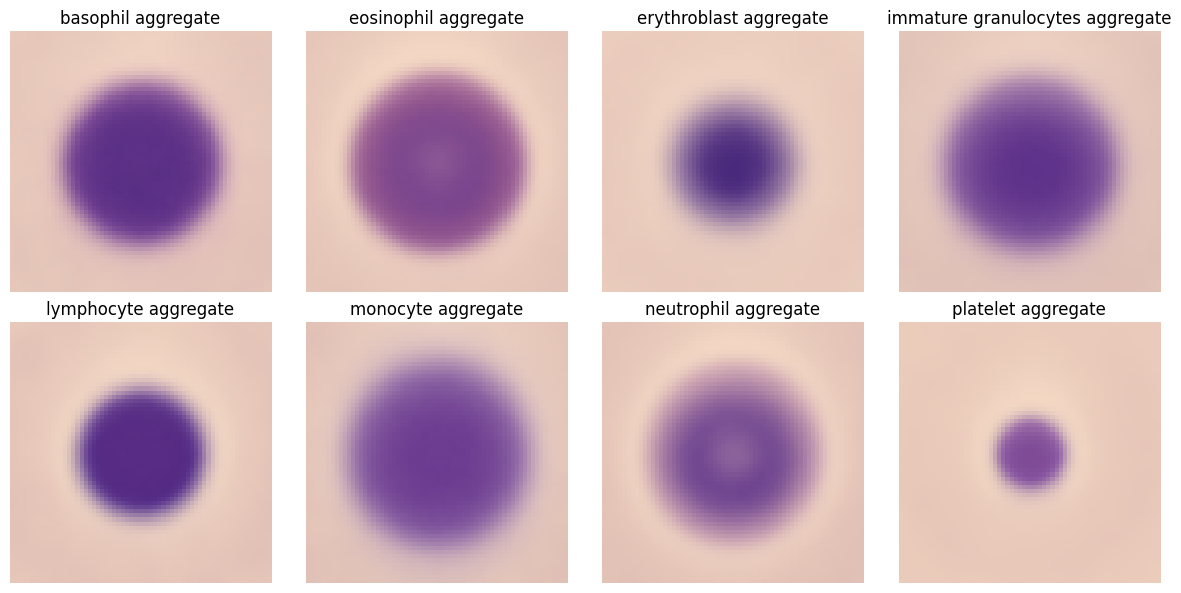

In [40]:
# plotting aggregated images for each cell class
# for 64x64x3 resolution
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    avg_image = average_dict_64[i]
    norm_image = avg_image/255
    ax.imshow(norm_image)  
    ax.axis('off') 
    ax.set_title(f"{label_dict[str(i)]} aggregate") 
plt.tight_layout() 
plt.show()

In [22]:
print(train_labels_64.shape, val_labels_64.shape, test_labels_64.shape)

(11959,) (1712,) (3421,)


In [24]:
train_labels_cat_64 = to_categorical(train_labels_64, num_classes=8)  # shape (N,8)
val_labels_cat_64   = to_categorical(val_labels_64,   num_classes=8)
test_labels_cat_64  = to_categorical(test_labels_64,  num_classes=8)
print(train_labels_cat_64.shape, val_labels_cat_64.shape, test_labels_cat_64.shape)

(11959, 8) (1712, 8) (3421, 8)


In [26]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
#    preprocessing_function=lambda img: tf.image.resize(img, (28,28))
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
#    preprocessing_function=lambda img: tf.image.resize(img, (28,28))
)

batch_size = 16 # change to 32

In [28]:
train_generator_64 = train_datagen.flow(
    train_images_64, 
    train_labels_cat_64,   
    batch_size=batch_size
)
val_generator_64 = test_datagen.flow(
    val_images_64,
    val_labels_cat_64,
    batch_size=batch_size
)
test_generator_64 = test_datagen.flow(
    test_images_64,
    test_labels_cat_64,
    batch_size=batch_size,
    shuffle=False
)

In [30]:
# ResNet101: model_101_64

base_101_64 = ResNet101(
    include_top=False,
    weights="imagenet",
    input_shape=(64, 64, 3)
)

x = base_101_64.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(8, activation="softmax")(x)

model_101_64 = Model(inputs=base_101_64.input, outputs=outputs)

In [46]:
# Train model_101_64

model_101_64.compile(
    optimizer=Adam(1e-4),
    loss="categorical_crossentropy",       
    metrics=[
        "accuracy",
        AUC(name="auc", multi_label=True, num_labels=8)
    ]
)
model_101_64.fit(
    train_generator_64,
    epochs=10,
    validation_data=val_generator_64
)

Epoch 1/10
748/748 [==============================] - 178s 233ms/step - loss: 0.4479 - accuracy: 0.8521 - auc: 0.9798 - val_loss: 5.5537 - val_accuracy: 0.2272 - val_auc: 0.6606
Epoch 2/10
748/748 [==============================] - 175s 234ms/step - loss: 0.1775 - accuracy: 0.9416 - auc: 0.9952 - val_loss: 0.1873 - val_accuracy: 0.9404 - val_auc: 0.9961
Epoch 3/10
748/748 [==============================] - 176s 236ms/step - loss: 0.1163 - accuracy: 0.9619 - auc: 0.9970 - val_loss: 0.1171 - val_accuracy: 0.9614 - val_auc: 0.9981
Epoch 4/10
748/748 [==============================] - 177s 237ms/step - loss: 0.0987 - accuracy: 0.9671 - auc: 0.9979 - val_loss: 0.2577 - val_accuracy: 0.9206 - val_auc: 0.9919
Epoch 5/10
748/748 [==============================] - 176s 235ms/step - loss: 0.0977 - accuracy: 0.9675 - auc: 0.9980 - val_loss: 0.1148 - val_accuracy: 0.9603 - val_auc: 0.9972
Epoch 6/10
748/748 [==============================] - 175s 234ms/step - loss: 0.0787 - accuracy: 0.9723 - auc:

In [47]:
# Evaluate model_101_64

test_loss_101_64, test_acc_101_64, test_auc_101_64 = model_101_64.evaluate(test_generator_64)
print(f"ResNet101 test accuracy for 64 pixels: {test_acc_101_64:.4f}")
print(f"ResNet101 test AUC for 64 pixels:      {test_auc_101_64:.4f}")

214/214 [==============================] - 13s 60ms/step - loss: 0.0934 - accuracy: 0.9693 - auc: 0.9978
ResNet101 test accuracy for 64 pixels: 0.9693
ResNet101 test AUC for 64 pixels:      0.9978


In [56]:
# Precision, recall, f1-score: model_101_64

y_prob_101_64 = model_101_64.predict(test_generator_64)
y_pred_101_64 = np.argmax(y_prob_101_64, axis=1)

y_true_64 = test_labels_64

class_names = [label_dict[str(i)] for i in range(8)]
print(classification_report(y_true_64, y_pred_101_64, target_names=class_names))

214/214 [==============================] - 14s 62ms/step
                       precision    recall  f1-score   support

             basophil       0.98      0.98      0.98       244
           eosinophil       0.99      1.00      1.00       624
         erythroblast       0.98      0.99      0.99       311
immature granulocytes       0.89      0.98      0.93       579
           lymphocyte       1.00      0.93      0.96       243
             monocyte       0.96      0.85      0.90       284
           neutrophil       0.99      0.96      0.98       666
             platelet       1.00      1.00      1.00       470

             accuracy                           0.97      3421
            macro avg       0.97      0.96      0.97      3421
         weighted avg       0.97      0.97      0.97      3421



In [57]:
# Performance per class model_101_64

cm_101_64 = confusion_matrix(y_true_64, y_pred_101_64)
per_class_acc_101_64 = cm_101_64.diagonal() / cm_101_64.sum(axis=1)
for i, acc in enumerate(per_class_acc_101_64):
    print(f"{class_names[i]:<20s} accuracy: {acc:.4f}")

basophil             accuracy: 0.9836
eosinophil           accuracy: 1.0000
erythroblast         accuracy: 0.9904
immature granulocytes accuracy: 0.9827
lymphocyte           accuracy: 0.9259
monocyte             accuracy: 0.8451
neutrophil           accuracy: 0.9610
platelet             accuracy: 1.0000


In [48]:
# ResNet50: model_50_64

base_50_64 = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(64, 64, 3)
)

x = base_50_64.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x) # try different dropout value
outputs = layers.Dense(8, activation="softmax")(x)

model_50_64 = Model(inputs=base_50_64.input, outputs=outputs)

In [49]:
# Train model_50_64

model_50_64.compile(
    optimizer=Adam(1e-4),
    loss="categorical_crossentropy",       
    metrics=[
        "accuracy",
        AUC(name="auc", multi_label=True, num_labels=8)
    ]
)
model_50_64.fit(
    train_generator_64,
    epochs=10,
    validation_data=val_generator_64
)

Epoch 1/10
748/748 [==============================] - 104s 137ms/step - loss: 0.4287 - accuracy: 0.8595 - auc: 0.9815 - val_loss: 3.2408 - val_accuracy: 0.1811 - val_auc: 0.6613
Epoch 2/10
748/748 [==============================] - 100s 134ms/step - loss: 0.1649 - accuracy: 0.9447 - auc: 0.9960 - val_loss: 0.2022 - val_accuracy: 0.9322 - val_auc: 0.9923
Epoch 3/10
748/748 [==============================] - 100s 134ms/step - loss: 0.1291 - accuracy: 0.9590 - auc: 0.9970 - val_loss: 0.1089 - val_accuracy: 0.9603 - val_auc: 0.9983
Epoch 4/10
748/748 [==============================] - 101s 135ms/step - loss: 0.0989 - accuracy: 0.9670 - auc: 0.9980 - val_loss: 0.1002 - val_accuracy: 0.9690 - val_auc: 0.9989
Epoch 5/10
748/748 [==============================] - 101s 135ms/step - loss: 0.0996 - accuracy: 0.9671 - auc: 0.9980 - val_loss: 0.1196 - val_accuracy: 0.9585 - val_auc: 0.9978
Epoch 6/10
748/748 [==============================] - 102s 136ms/step - loss: 0.0861 - accuracy: 0.9718 - auc:

In [50]:
# Evaluate model_50_64

test_loss_50_64, test_acc_50_64, test_auc_50_64 = model_50_64.evaluate(test_generator_64)
print(f"ResNet50 test accuracy for 64 pixels: {test_acc_50_64:.4f}")
print(f"ResNet50 test AUC for 64 pxiels:      {test_auc_50_64:.4f}")

214/214 [==============================] - 7s 31ms/step - loss: 0.1145 - accuracy: 0.9676 - auc: 0.9956
ResNet50 test accuracy for 64 pixels: 0.9676
ResNet50 test AUC for 64 pxiels:      0.9956


In [52]:
# Precision, recall, f1-score: model_50_64

y_prob_50_64 = model_50_64.predict(test_generator_64)
y_pred_50_64 = np.argmax(y_prob_50_64, axis=1)

y_true_64 = test_labels_64

class_names = [label_dict[str(i)] for i in range(8)]
print(classification_report(y_true_64, y_pred_50_64, target_names=class_names))

214/214 [==============================] - 7s 32ms/step
                       precision    recall  f1-score   support

             basophil       0.98      0.98      0.98       244
           eosinophil       1.00      1.00      1.00       624
         erythroblast       0.98      0.97      0.98       311
immature granulocytes       0.90      0.96      0.92       579
           lymphocyte       0.94      0.98      0.96       243
             monocyte       1.00      0.81      0.89       284
           neutrophil       0.97      0.98      0.98       666
             platelet       1.00      1.00      1.00       470

             accuracy                           0.97      3421
            macro avg       0.97      0.96      0.96      3421
         weighted avg       0.97      0.97      0.97      3421



In [53]:
# Performance per class: model_50_64

cm_50_64 = confusion_matrix(y_true_64, y_pred_50_64)
per_class_acc_50_64 = cm_50_64.diagonal() / cm_50_64.sum(axis=1)
for i, acc in enumerate(per_class_acc_50_64):
    print(f"{class_names[i]:<20s} accuracy: {acc:.4f}")

basophil             accuracy: 0.9836
eosinophil           accuracy: 1.0000
erythroblast         accuracy: 0.9743
immature granulocytes accuracy: 0.9551
lymphocyte           accuracy: 0.9835
monocyte             accuracy: 0.8063
neutrophil           accuracy: 0.9790
platelet             accuracy: 1.0000


- plot the loss vs. epoch function
- change the step size by change the batch size = 32

### Next step:
- precision recall f1 score 
- check accuracy by class
- investigate performance by the class
- try different drop_out rate
- try on other size of the picture.
- time magic function

In [67]:
from tensorflow.keras.callbacks import History as HistoryClass

ip = get_ipython()
outs = ip.user_ns["Out"]

history_cells = [num for num, obj in outs.items()
                 if isinstance(obj, HistoryClass)]
print("Found History outputs in cells:", history_cells)

Found History outputs in cells: [29, 32, 46, 49]


In [68]:
history1 = outs[history_cells[0]]
history2 = outs[history_cells[1]]
history3 = outs[history_cells[2]]
history4 = outs[history_cells[3]]

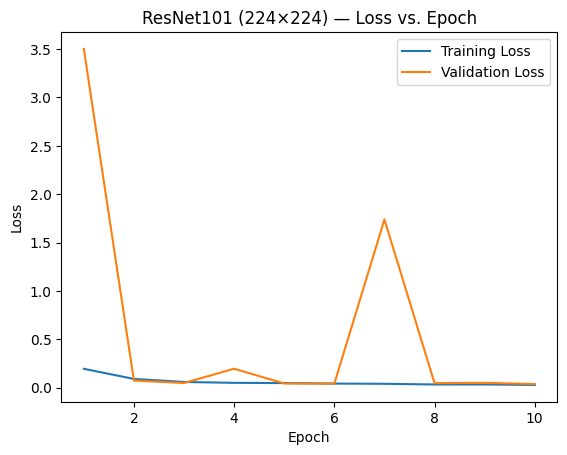

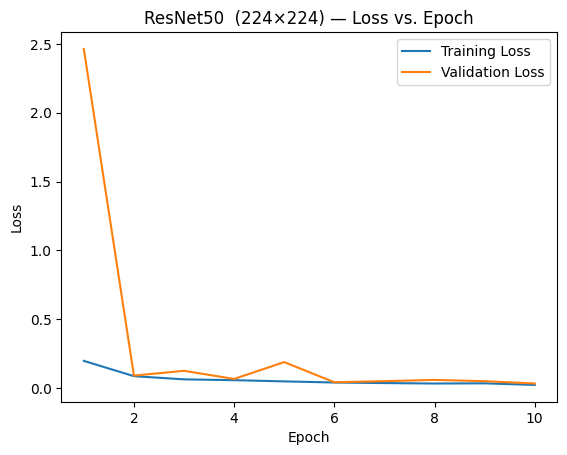

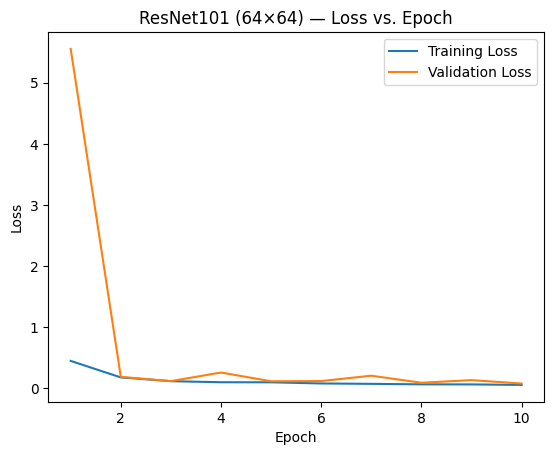

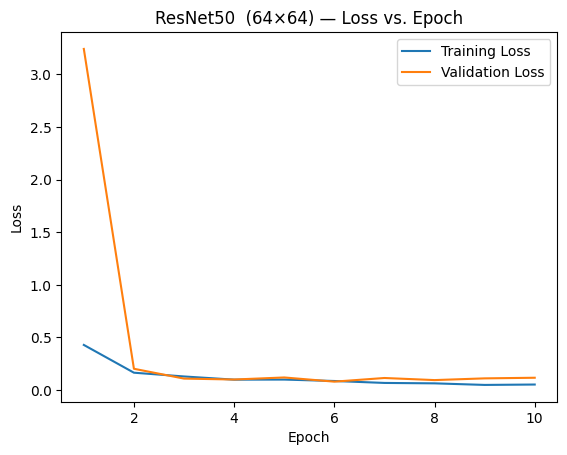

In [72]:
import matplotlib.pyplot as plt

histories = [history1, history2, history3, history4]
model_names = [
    'ResNet101 (224×224)', 
    'ResNet50  (224×224)',
    'ResNet101 (64×64)', 
    'ResNet50  (64×64)'
]

for name, hist in zip(model_names, histories):
    epochs = range(1, len(hist.history['loss']) + 1)
    plt.figure()
    plt.plot(epochs, hist.history['loss'],    label='Training Loss')
    plt.plot(epochs, hist.history['val_loss'],label='Validation Loss')
    plt.title(f'{name} — Loss vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

### Resolution: 128x128

In [32]:
# downloads bloodmnist_128.npz file 
# at /Users/username/.medmnist/bloodmnist_128.npz
# 128 pixel resolution
# image dimension is 128x128x3
train_df_128 = BloodMNIST(split="train", download=True, size=128)
val_df_128 = BloodMNIST(split="val", download=True, size=128)
test_df_128 = BloodMNIST(split="test", download=True, size=128)

In [36]:
# copy downloaded bloodmnist.npz file to current working directory
# cp -r /Users/username/.medmnist/bloodmnist_128.npz .
# load in file and check names of attributes
data_128 = np.load("bloodmnist_128.npz")
data_128.files

['train_images',
 'train_labels',
 'val_images',
 'val_labels',
 'test_images',
 'test_labels']

In [38]:
# extracting images and labels
# train set
train_images_128 = data_128["train_images"]
train_labels_128 = data_128["train_labels"].flatten()

# validation_set
val_images_128 = data_128["val_images"]
val_labels_128 = data_128["val_labels"].flatten()

# test_set
test_images_128 = data_128["test_images"]
test_labels_128 = data_128["test_labels"].flatten()

In [40]:
# concatenanting all images and labels 
cat_images_128 = np.concatenate([train_images_128, val_images_128, test_images_128])
cat_labels_128 = np.concatenate([train_labels_128, val_labels_128, test_labels_128])

In [42]:
# creating a dictionary as label:[images]
class_dict_128 = {k:[] for k in np.arange(8)}
for i, j in zip(cat_labels_128, cat_images_128):
    class_dict_128[i].append(j)

In [44]:
# calculating the average image for each class
# creating dictionary as label:avg_image
average_dict_128 = {k:[] for k in np.arange(8)}
for i in class_dict_128:
    class_images = class_dict_128[i]
    class_all = np.stack(class_images, axis=0) 
    class_avg = np.mean(class_all, axis=0)
    average_dict_128[i] = class_avg

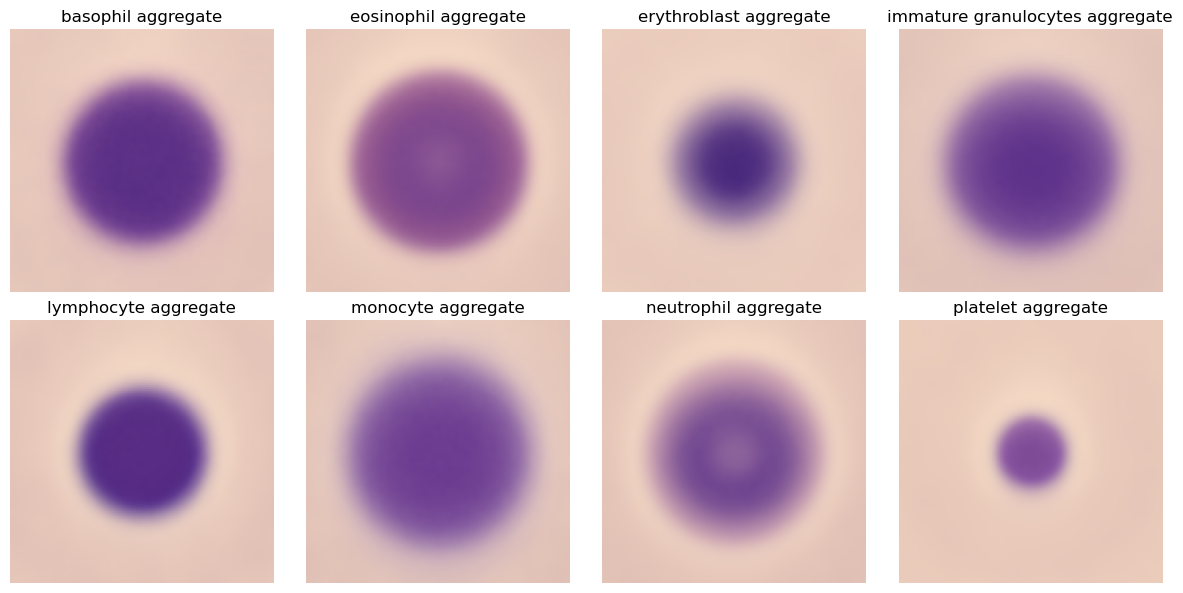

In [76]:
# plotting aggregated images for each cell class
# for 128x128x3 resolution
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    avg_image = average_dict_128[i]
    norm_image = avg_image/255
    ax.imshow(norm_image)  
    ax.axis('off') 
    ax.set_title(f"{label_dict[str(i)]} aggregate") 
plt.tight_layout() 
plt.show()

In [80]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.7/252.7 MB 56.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 72.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 51.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.4/670.4 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 68.4 MB/s eta 0:00:00


In [46]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet101, ResNet50
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import AUC
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

In [48]:
# check the dimension of the train, validation, and test sets 
print(train_labels_128.shape, val_labels_128.shape, test_labels_128.shape)

(11959,) (1712,) (3421,)


In [50]:
# convert labels to categorical (one-hot encoding) --> 1,0 (required for categorical cross-entropy)

train_labels_cat_128 = to_categorical(train_labels_128, num_classes=8)  # shape (N,8)
val_labels_cat_128   = to_categorical(val_labels_128,   num_classes=8)
test_labels_cat_128  = to_categorical(test_labels_128,  num_classes=8)
print(train_labels_cat_128.shape, val_labels_cat_128.shape, test_labels_cat_128.shape)

(11959, 8) (1712, 8) (3421, 8)


In [88]:
# Image data augmentation & normalization

# ImageDataGenerator, generates batches of image data with rt augmentation
## prevents overfitting, expands dataset without collecting more images

train_datagen = ImageDataGenerator(
    rescale=1./255,
    # shearing transformation (slanting/ stretching images diagonally) +/- 20%
    shear_range=0.2, 
    # random zooms in/out up to 20%
    zoom_range=0.2,
    # randomly flips images horizontally, object is symmetrical or orientation-invariant
    horizontal_flip=True
#    preprocessing_function=lambda img: tf.image.resize(img, (28,28))
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
#    preprocessing_function=lambda img: tf.image.resize(img, (28,28))
)

# defines how many images are processed at once before the model updates the weights
batch_size = 16 # change to 32

In [55]:
# DataLoader objects for training, validation, test
## creates batches of image-label pairs with augmentation

train_generator_128 = train_datagen.flow(
    train_images_128, 
    train_labels_cat_128,   
    batch_size=batch_size
)
val_generator_128 = test_datagen.flow(
    val_images_128,
    val_labels_cat_128,
    batch_size=batch_size
)
test_generator_128 = test_datagen.flow(
    test_images_128,
    test_labels_cat_128,
    batch_size=batch_size,
    shuffle=False # ensures consistent order for prediction, important for confusion matrices and comparison
)

In [102]:
# ResNet50 model: model_50_128

base_50_128 = ResNet50(
    include_top=False, # remove original fully connected classification layers for ImageNet, add our own 8 blood cell types
    weights="imagenet", # load the model weights trained on ImageNet
    input_shape=(128, 128, 3) 
)

x = base_50_128.output # output of the last layer
x = layers.GlobalAveragePooling2D()(x) # reduce spatial dimension, prevents overfitting
x = layers.Dropout(0.3)(x) # sets 30% of input units to zero during training, regularisation for reducing overfitting
outputs = layers.Dense(8, activation="softmax")(x) # adds final clafficiation layer with 8 output units

model_50_128 = Model(inputs=base_50_128.input, outputs=outputs)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [104]:
# Train model_50_128

model_50_128.compile(
    # how to optimise
    optimizer=Adam(1e-4), 
    # what to optimise   
    loss="categorical_crossentropy", 
    # what to report
    metrics=[
        "accuracy",
        AUC(name="auc", multi_label=True, num_labels=8)
    ]
)
model_50_128.fit(
    train_generator_128,
    epochs=10,
    validation_data=val_generator_128
)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
748/748 ━━━━━━━━━━━━━━━━━━━━ 727s 958ms/step - accuracy: 0.8479 - auc: 0.9732 - loss: 0.4568 - val_accuracy: 0.1653 - val_auc: 0.7113 - val_loss: 4.1312
Epoch 2/10
748/748 ━━━━━━━━━━━━━━━━━━━━ 698s 933ms/step - accuracy: 0.9680 - auc: 0.9980 - loss: 0.1000 - val_accuracy: 0.9404 - val_auc: 0.9857 - val_loss: 0.4858
Epoch 3/10
748/748 ━━━━━━━━━━━━━━━━━━━━ 688s 919ms/step - accuracy: 0.9759 - auc: 0.9989 - loss: 0.0672 - val_accuracy: 0.9725 - val_auc: 0.9986 - val_loss: 0.0716
Epoch 4/10
748/748 ━━━━━━━━━━━━━━━━━━━━ 704s 941ms/step - accuracy: 0.9795 - auc: 0.9988 - loss: 0.0630 - val_accuracy: 0.8943 - val_auc: 0.9899 - val_loss: 0.3670
Epoch 5/10
748/748 ━━━━━━━━━━━━━━━━━━━━ 700s 936ms/step - accuracy: 0.9834 - auc: 0.9986 - loss: 0.0473 - val_accuracy: 0.9761 - val_auc: 0.9991 - val_loss: 0.0759
Epoch 6/10
748/748 ━━━━━━━━━━━━━━━━━━━━ 706s 943ms/step - accuracy: 0.9853 - auc: 0.9984 - loss: 0.0424 - val_accuracy: 0.9801 - val_auc: 0.9995 - val_loss: 0.0537
Epoch 7/10
748/7

In [106]:
# Evaluate model_50_128

test_loss_50_128, test_acc_50_128, test_auc_50_128 = model_50_128.evaluate(test_generator_128)
print(f"ResNet50 test accuracy for 128 pixels: {test_acc_50_128:.4f}")
print(f"ResNet50 test AUC for 128 pixels:      {test_auc_50_128:.4f}")

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


214/214 ━━━━━━━━━━━━━━━━━━━━ 37s 172ms/step - accuracy: 0.9679 - auc: 0.9986 - loss: 0.0817
ResNet50 test accuracy for 128 pixels: 0.9687
ResNet50 test AUC for 128 pixels:      0.9984


In [108]:
# Precision, recall, F1 score: model_50_128

y_prob_50_128 = model_50_128.predict(test_generator_128)
y_pred_50_128 = np.argmax(y_prob_50_128, axis=1)

y_true_128 = test_labels_128

class_names = [label_dict[str(i)] for i in range(8)]
print(classification_report(y_true_128, y_pred_50_128, target_names=class_names))

214/214 ━━━━━━━━━━━━━━━━━━━━ 37s 171ms/step
                       precision    recall  f1-score   support

             basophil       0.89      1.00      0.94       244
           eosinophil       1.00      1.00      1.00       624
         erythroblast       0.93      1.00      0.96       311
immature granulocytes       0.96      0.90      0.93       579
           lymphocyte       0.96      0.98      0.97       243
             monocyte       1.00      0.88      0.94       284
           neutrophil       0.96      0.99      0.97       666
             platelet       1.00      1.00      1.00       470

             accuracy                           0.97      3421
            macro avg       0.96      0.97      0.96      3421
         weighted avg       0.97      0.97      0.97      3421



In [112]:
# Accuracy per class: model_50_128

cm_50_128 = confusion_matrix(y_true_128, y_pred_50_128)
per_class_acc_50_128 = cm_50_128.diagonal() / cm_50_128.sum(axis=1)
for i, acc in enumerate(per_class_acc_50_128):
    print(f"{class_names[i]:<20s} accuracy: {acc:.4f}")

basophil             accuracy: 1.0000
eosinophil           accuracy: 0.9984
erythroblast         accuracy: 0.9968
immature granulocytes accuracy: 0.9016
lymphocyte           accuracy: 0.9835
monocyte             accuracy: 0.8803
neutrophil           accuracy: 0.9865
platelet             accuracy: 0.9979


In [57]:
# ResNet101 model: model_101_128

# loads the ResNet-101 architecture pretrained on ImageNet (unless weights are None)
base_101_128 = ResNet101(
    # remove the default final Dense (fully connected) layer for ImageNet classification (1000 classes)
    include_top=False,
    # load pretrained weights from ImageNet, helping with transfer learning
    weights="imagenet",
    input_shape=(128, 128, 3) # 128x128 with 3 RGB
)

# access the output of the base ResNet model
x = base_101_128.output 

# replace the flattening layer with Global Average Pooling
## reduce feature maps to 1 value per channel
## lower the number of parameters
## helps prevent overfitting 
x = layers.GlobalAveragePooling2D()(x)

# dropout randomly turns off 30% neurons during training
## regularisation, reduce overfitting
x = layers.Dropout(0.3)(x)

# final classifier layer
## softmax = outputs a probability distribution over classes
# 8 = class
outputs = layers.Dense(8, activation="softmax")(x) 

model_101_128 = Model(inputs=base_101_128.input, outputs=outputs)

In [59]:
# Train model_101_128
model_101_128.compile(
    optimizer=Adam(1e-4), 
    # the learning rate should be further tuned
    # Adam is usually the first algorithm to try firther, but we can try other optimizers
    loss="categorical_crossentropy",   
    metrics=[
        "accuracy",
        AUC(name="auc", multi_label=True, num_labels=8)
    ]
)

model_101_128.fit(
    train_generator_128,
    epochs=10,
    validation_data=val_generator_128
)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
748/748 ━━━━━━━━━━━━━━━━━━━━ 1418s 2s/step - accuracy: 0.8586 - auc: 0.9750 - loss: 0.4298 - val_accuracy: 0.2629 - val_auc: 0.6419 - val_loss: 5.6119
Epoch 2/10
748/748 ━━━━━━━━━━━━━━━━━━━━ 1393s 2s/step - accuracy: 0.9601 - auc: 0.9976 - loss: 0.1224 - val_accuracy: 0.9743 - val_auc: 0.9992 - val_loss: 0.0608
Epoch 3/10
748/748 ━━━━━━━━━━━━━━━━━━━━ 1391s 2s/step - accuracy: 0.9757 - auc: 0.9973 - loss: 0.0775 - val_accuracy: 0.9854 - val_auc: 0.9996 - val_loss: 0.0423
Epoch 4/10
748/748 ━━━━━━━━━━━━━━━━━━━━ 1388s 2s/step - accuracy: 0.9785 - auc: 0.9991 - loss: 0.0626 - val_accuracy: 0.9667 - val_auc: 0.9983 - val_loss: 0.0865
Epoch 5/10
748/748 ━━━━━━━━━━━━━━━━━━━━ 1399s 2s/step - accuracy: 0.9803 - auc: 0.9993 - loss: 0.0536 - val_accuracy: 0.9731 - val_auc: 0.9985 - val_loss: 0.0883
Epoch 6/10
748/748 ━━━━━━━━━━━━━━━━━━━━ 1395s 2s/step - accuracy: 0.9868 - auc: 0.9992 - loss: 0.0404 - val_accuracy: 0.9778 - val_auc: 0.9972 - val_loss: 0.0870
Epoch 7/10
748/748 ━━━━━━━━━

In [61]:
# Evaluate model_101_128

test_loss_101_128, test_acc_101_128, test_auc_101_128 = model_101_128.evaluate(test_generator_128)
print(f"ResNet101 test accuracy for 128 pixels: {test_acc_101_128:.4f}")
print(f"ResNet101 test AUC for 128 pixels:      {test_auc_101_128:.4f}")

214/214 ━━━━━━━━━━━━━━━━━━━━ 69s 320ms/step - accuracy: 0.9776 - auc: 0.9984 - loss: 0.0731
ResNet101 test accuracy for 128 pixels: 0.9807
ResNet101 test AUC for 128 pixels:      0.9990


In [67]:
# Precision, recall, f1-score: model_101_128

y_prob_101_128 = model_101_128.predict(test_generator_128)
y_pred_101_128 = np.argmax(y_prob_101_128, axis=1)

y_true_128 = test_labels_128

class_names = [label_dict[str(i)] for i in range(8)]
print(classification_report(y_true_128, y_pred_101_128, target_names=class_names))

214/214 ━━━━━━━━━━━━━━━━━━━━ 66s 309ms/step
                       precision    recall  f1-score   support

             basophil       1.00      0.98      0.99       244
           eosinophil       1.00      1.00      1.00       624
         erythroblast       0.98      0.99      0.99       311
immature granulocytes       0.94      0.98      0.96       579
           lymphocyte       1.00      0.94      0.97       243
             monocyte       0.95      0.99      0.97       284
           neutrophil       0.99      0.95      0.97       666
             platelet       1.00      1.00      1.00       470

             accuracy                           0.98      3421
            macro avg       0.98      0.98      0.98      3421
         weighted avg       0.98      0.98      0.98      3421



In [69]:
# Accuracy per class: model_101_128

cm_101_128 = confusion_matrix(y_true_128, y_pred_101_128)
per_class_acc_101_128 = cm_101_128.diagonal() / cm_101_128.sum(axis=1)
for i, acc in enumerate(per_class_acc_101_128):
    print(f"{class_names[i]:<20s} accuracy: {acc:.4f}")

basophil             accuracy: 0.9754
eosinophil           accuracy: 1.0000
erythroblast         accuracy: 0.9871
immature granulocytes accuracy: 0.9845
lymphocyte           accuracy: 0.9424
monocyte             accuracy: 0.9930
neutrophil           accuracy: 0.9550
platelet             accuracy: 0.9979


In [71]:
from tensorflow.keras.callbacks import History as HistoryClass

ip = get_ipython()
outs = ip.user_ns["Out"]

history_cells = [num for num, obj in outs.items()
                 if isinstance(obj, HistoryClass)]
print("Found History outputs in cells:", history_cells)

Found History outputs in cells: [59]


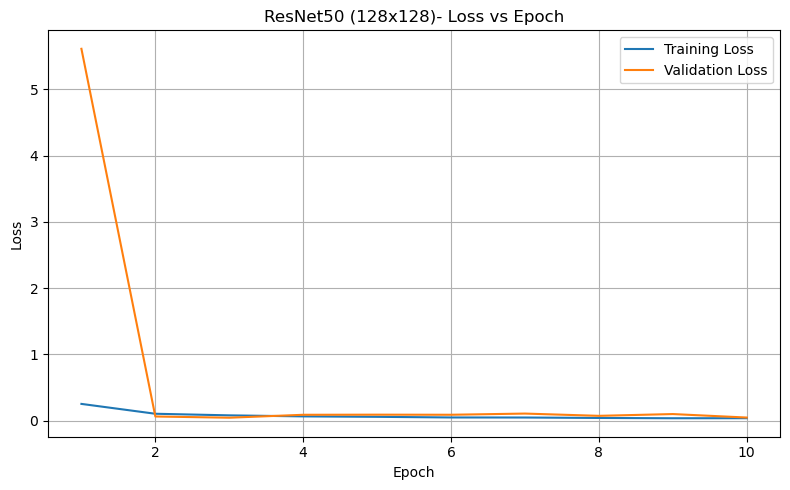

In [91]:
# ResNet50 (128x128): Loss vs Epoch

import matplotlib.pyplot as plt

history5 = outs[59] # get history for ResNet101_128

epochs = range(1, len(history5.history['loss']) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, history5.history['loss'], label='Training Loss')
plt.plot(epochs, history5.history['val_loss'], label='Validation Loss')
plt.title('ResNet50 (128x128)- Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()